#Customer Segmentation using Clustering & Dimensionality Reduction on Online Retail Dataset

As part of this project, we are using dimensionality reduction and clustering to segment the users from an online retail dataset. We use principal component analysis (PCA) for dimensionality reduction. Then we apply the following clustering techniques on the reduced dataset:

1. K-Means Clustering
2. K-Mean Mini Batch Clustering
3. Gaussian Mixture Model

Furthermore, we perform RFM segmentation on the dataset to segment the users based on their spending habits using the following clustering algorithms:

1. K-Means Clustering
2. Spectral Clustering
3. Gaussian Mixture Model



In [ ]:
# Importing libraries required 
'''We are using sklearn, matplotlib, pandas, seaborn for operations'''

!pip install yellowbrick
from google.colab import drive
drive.mount('/content/drive')

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, Birch,MiniBatchKMeans,SpectralClustering
from yellowbrick.cluster import KElbowVisualizer
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import homogeneity_score,completeness_score,make_scorer,silhouette_score,mean_squared_error


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Importing the data set in a pandas dataframe
# data_set = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/USML/Project/online_retail_II.csv')
data_set = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/online_retail_II.csv')
data_set.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [ ]:
# Getting a overview of the data set
data_set.describe()

,Quantity,Price,Customer ID
count,1.067371e+06,1.067371e+06,824364.000000
mean,9.938898e+00,4.649388e+00,15324.638504
std,1.727058e+02,1.235531e+02,1697.464450
min,-8.099500e+04,-5.359436e+04,12346.000000
25%,1.000000e+00,1.250000e+00,13975.000000
50%,3.000000e+00,2.100000e+00,15255.000000
75%,1.000000e+01,4.150000e+00,16797.000000
max,8.099500e+04,3.897000e+04,18287.000000


##Data Cleaning and manipulation
Here, we perform data cleaning by removing null values, converting to lower case, converting the data type of a column to datetime and then also removing cancelled orders based on invoice ID. Finally, we also create a new column for total price which is calculated by multiplying quantity and price columns.

In [ ]:
# Removing records where customer ID is null or NA
data_set = data_set[data_set['Customer ID'].notna()]

In [ ]:
# Converting the description column to lower case
data_set['Description'] = data_set['Description'].str.lower()

In [ ]:
# Changing the invoice date to datetime format from object
data_set["InvoiceDate"] = pd.to_datetime(data_set["InvoiceDate"])

In [ ]:
# Removing of cancelled orders from the data set
data_set[data_set["Invoice"].str.contains("C", na=False)]
data_set = data_set[~data_set["Invoice"].str.contains("C", na=False)]

In [ ]:
# Creating a total price column
data_set["TotalPrice"]=data_set["Quantity"]*data_set["Price"]

##Exploratory Data Analysis
In this section, we explore the data in detail to extract some insights on some of the columns of the dataset. 

Top 10 countries with the highest spending:

<ipython-input-9-d2d95558ef70>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_aggregate = data_set.groupby('Country')['Price','Quantity'].sum()


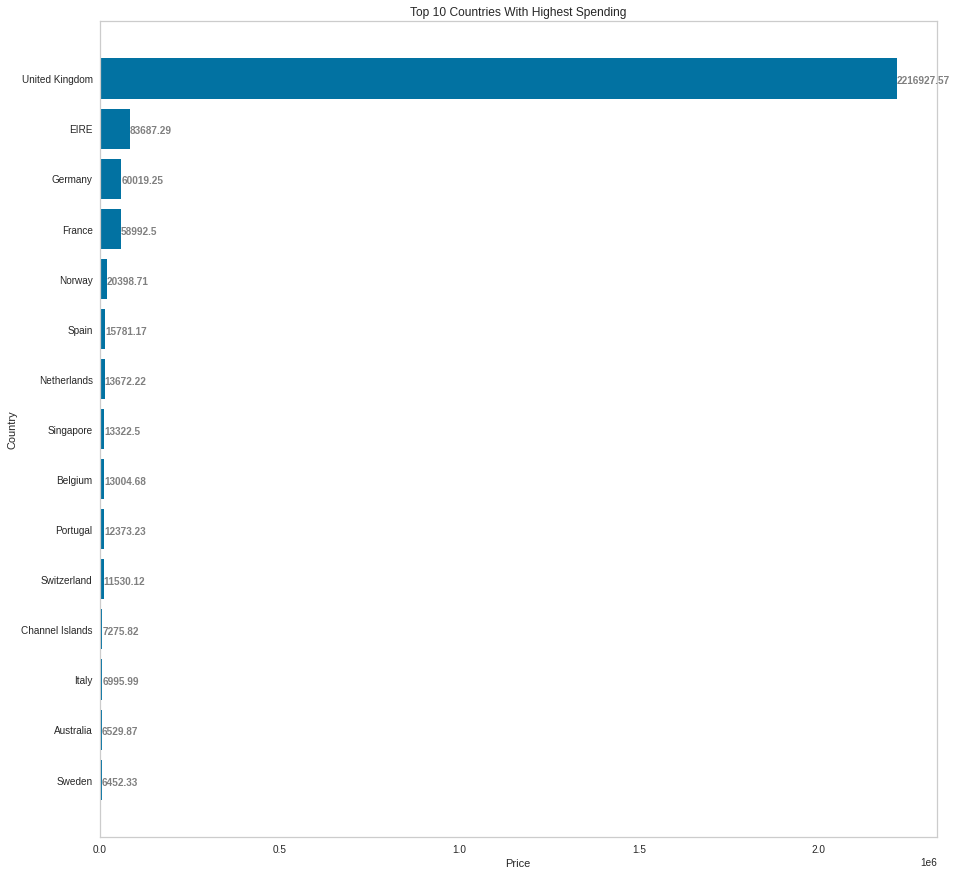

In [ ]:
# Finding Top 10 Countries With Highest Spending
df_aggregate = data_set.groupby('Country')['Price','Quantity'].sum()
df_aggregate = pd.DataFrame(df_aggregate, columns = ['Price','Quantity'])
df_aggregate = df_aggregate.reset_index(level=0)
df_aggregate = df_aggregate.sort_values(by= 'Price',ascending = False)

fig,ax = plt.subplots(figsize = (15,15))

ax.barh(df_aggregate['Country'][:15], df_aggregate['Price'][:15])
ax.invert_yaxis()

for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')
 
ax.set_title('Top 10 Countries With Highest Spending',
             loc ='center', )
ax.set_xlabel('Price')
ax.set_ylabel('Country')
ax.grid(False)
plt.show()

Top 10 countries with the most number of purchases:

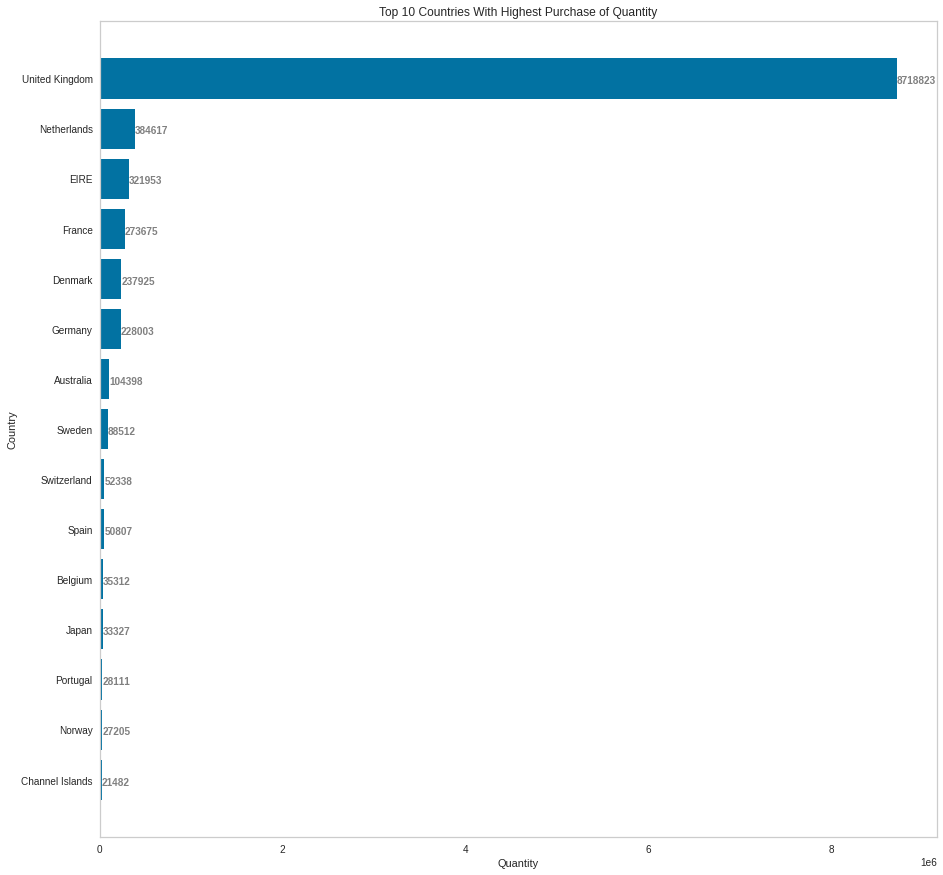

In [ ]:
#Getting Top 10 Countries With Highest Purchase of Quantity
df_aggregate = df_aggregate.sort_values(by= 'Quantity',ascending = False)
fig,ax = plt.subplots(figsize = (15,15))

ax.barh(df_aggregate['Country'][:15], df_aggregate['Quantity'][:15])
ax.invert_yaxis()

for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')
 
ax.set_title('Top 10 Countries With Highest Purchase of Quantity',
             loc ='center', )
ax.set_xlabel('Quantity')
ax.set_ylabel('Country')
ax.grid(False)
plt.show()

Purchase trend over time:

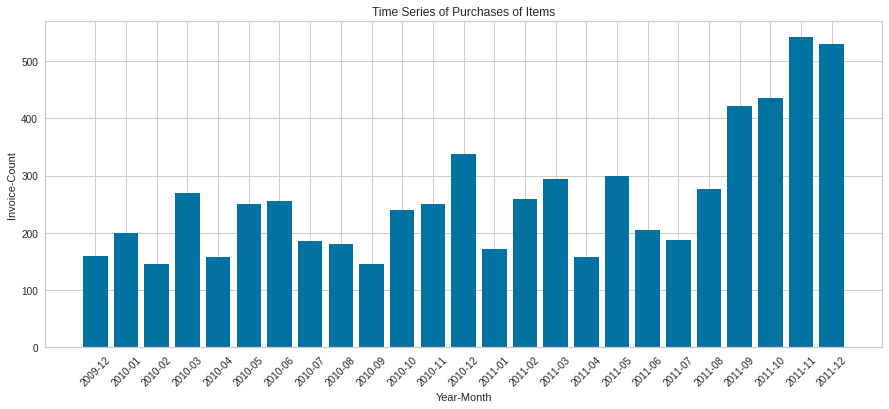

In [ ]:
# Time Series of purchases
df_time = data_set.groupby('InvoiceDate')['Invoice'].count()
df_time = pd.DataFrame(df_time, columns = ['Invoice'])
df_time = df_time.reset_index(level=0)
df_time['InvoiceDate'] = pd.to_datetime(df_time['InvoiceDate']).dt.strftime('%Y-%m')
df_time = df_time.sort_values(by='InvoiceDate')

fig, ax = plt.subplots(figsize=(15, 6))
ax.bar(df_time['InvoiceDate'], df_time['Invoice'])
ax.set_title('Time Series of Purchases of Items',
             loc ='center', )
ax.set_xlabel('Year-Month')
ax.set_ylabel('Invoice-Count')
ax.tick_params(axis='x', rotation=45)

Top 10 most purchased items:

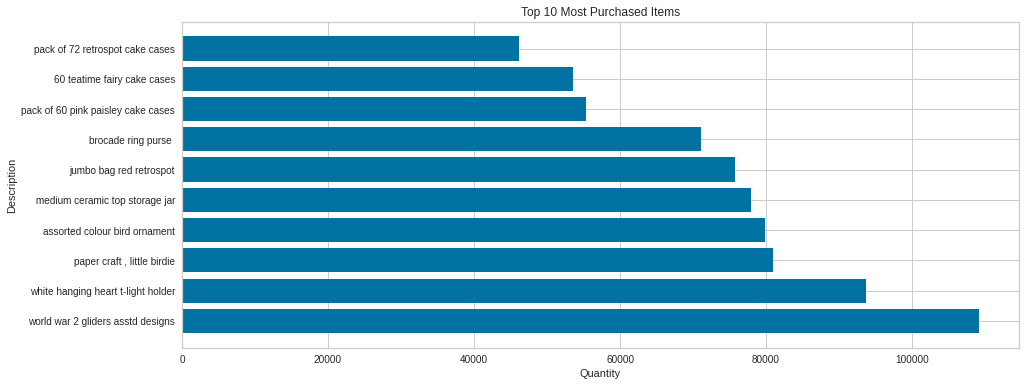

In [ ]:
# Getting the Top 10 purchased Items
df_quantity = data_set.groupby('Description')['Quantity'].sum() #Description change to it 
df_quantity = pd.DataFrame(df_quantity, columns = ['Quantity'])
df_quantity = df_quantity.reset_index(level=0)
df_quantity = df_quantity.sort_values(by= 'Quantity',ascending = False)

fig, ax = plt.subplots(figsize=(15, 6))
ax.barh(df_quantity['Description'][:10], df_quantity['Quantity'][:10])
ax.set_title('Top 10 Most Purchased Items',
             loc ='center', )
ax.set_xlabel('Quantity')
ax.set_ylabel('Description')
ax.tick_params(axis='x')

Top 10 customers with the most amount spent:

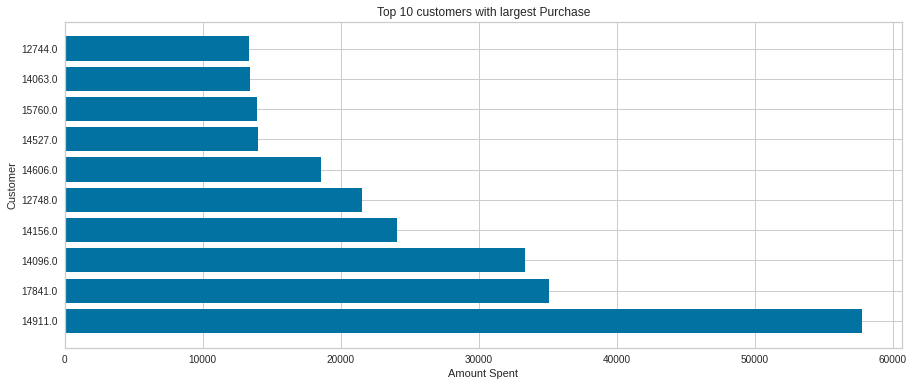

In [ ]:
# Getting the top 10 customer id with highest amount spent

df_customer = data_set.groupby('Customer ID')['Price'].sum()

df_customer = pd.DataFrame(df_customer, columns = ['Price'])
df_customer = df_customer.reset_index(level=0)
df_customer = df_customer.sort_values(by= 'Price',ascending = False)
df_customer["Customer ID"] = df_customer["Customer ID"].values.astype(str)

fig, ax = plt.subplots(figsize=(15, 6))
ax.barh(df_customer['Customer ID'][:10], df_customer['Price'][:10])
ax.set_title('Top 10 customers with largest Purchase',
             loc ='center', )
ax.set_xlabel('Amount Spent')
ax.set_ylabel('Customer')
ax.tick_params(axis='x')

Extracting the percentage of monetary contribution by country:

In [ ]:
# To get the Share of Country in the data set 
pattern = "C\d+"

data = data_set[data_set['Invoice'].str.contains(pattern, na=False)==False]

col1=data["Country"].value_counts(sort=True).rename("Country #")
col2=data["Country"].value_counts(normalize=True,sort=True).rename("Country %")
reg_data= pd.concat([col1, col2], axis = 1)

reg_data

,Country #,Country %
United Kingdom,725296,0.900295
Germany,16703,0.020733
EIRE,15745,0.019544
France,13813,0.017146
Netherlands,5093,0.006322
Spain,3720,0.004618
Belgium,3069,0.003809
Switzerland,3012,0.003739
Portugal,2446,0.003036
Australia,1815,0.002253


##Data Preprocessing and Dimensionality Reduction
In this section, we use the label encoder to encode the categorical columns into numerical values. Then, we use StandardScaler() to scale the values and thus reduce outliers. Finally, we use PCA to reduce the number of dimensions to 3.

In [ ]:
# Creating a new data frame with encoded data for dimensionality reduction and other tasks
data_set_encoded = pd.DataFrame()
data_set_encoded['Invoice'] = data_set['Invoice']
data_set_encoded['Quantity'] = data_set['Quantity']
data_set_encoded['Price'] = data_set['Price']
data_set_encoded['Customer ID'] = data_set['Customer ID']
data_set_encoded['TotalPrice'] = data_set['TotalPrice']

In [ ]:
# Using label encoder for converting categorical columns to numerical
label_encoder = LabelEncoder()
data_set_encoded['StockCode'] = label_encoder.fit_transform(data_set['StockCode'])
data_set_encoded['Description'] = label_encoder.fit_transform(data_set['Description'])
data_set_encoded['Country'] = label_encoder.fit_transform(data_set['Country'])

In [ ]:
# Standardizing the data frame for scaling the values
scaled_values = StandardScaler().fit_transform(data_set_encoded)
df_scaled_val = pd.DataFrame(scaled_values)
df_scaled_val.columns = ['Invoice','StockCode','Quantity','Price','Customer ID','TotalPrice','Description','Country']

In [ ]:
# Creating a PCA function 
pca = PCA(n_components = 3)
pca_transformed = pca.fit_transform(df_scaled_val)

# Creating the PCA dataframe
pca_df = pd.DataFrame(pca_transformed,columns = ['col1', 'col2','col3'])

# Taking the values for model fitting
pca_data = pca_df.iloc[:,:].values

# Creating a 2-d Martix for plotting the data later in graph
values_df = df_scaled_val[['Invoice','StockCode','Quantity','Price','Customer ID','TotalPrice','Description','Country']].values

#Data Modelling

Firstly, we get the optimal number of clusters using the K-Means Elbow Method. Then, we use the clustering techniques to get the clusters of the users.

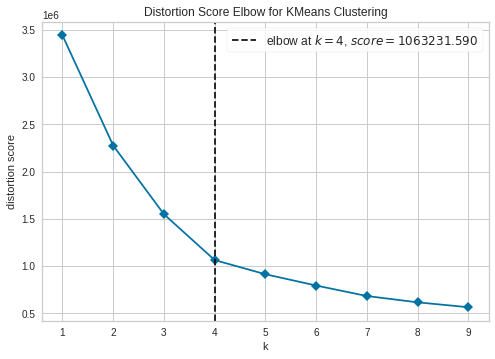

In [ ]:
# Creating a KMeans Model and determining n_components by the Elbow method
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(1,10), timings=False
)

# Fit the data to the visualizer
visualizer.fit(pca_data)        
visualizer.show() 

##K-Means Clustering:

In [ ]:
# Creating KMeans model with n_clusters = 4, found by the elbow method
model2 = KMeans(n_clusters= 4)
kmeans_labels = model2.fit_predict(pca_data)

print('Number of Points in Cluster 1:',np.count_nonzero(kmeans_labels == 0))
print('Number of Points in Cluster 2:',np.count_nonzero(kmeans_labels == 1))
print('Number of Points in Cluster 3:',np.count_nonzero(kmeans_labels == 2))
print('Number of Points in Cluster 4:',np.count_nonzero(kmeans_labels == 3))

Number of Points in Cluster 1: 375212
Number of Points in Cluster 2: 2
Number of Points in Cluster 3: 71995
Number of Points in Cluster 4: 358411


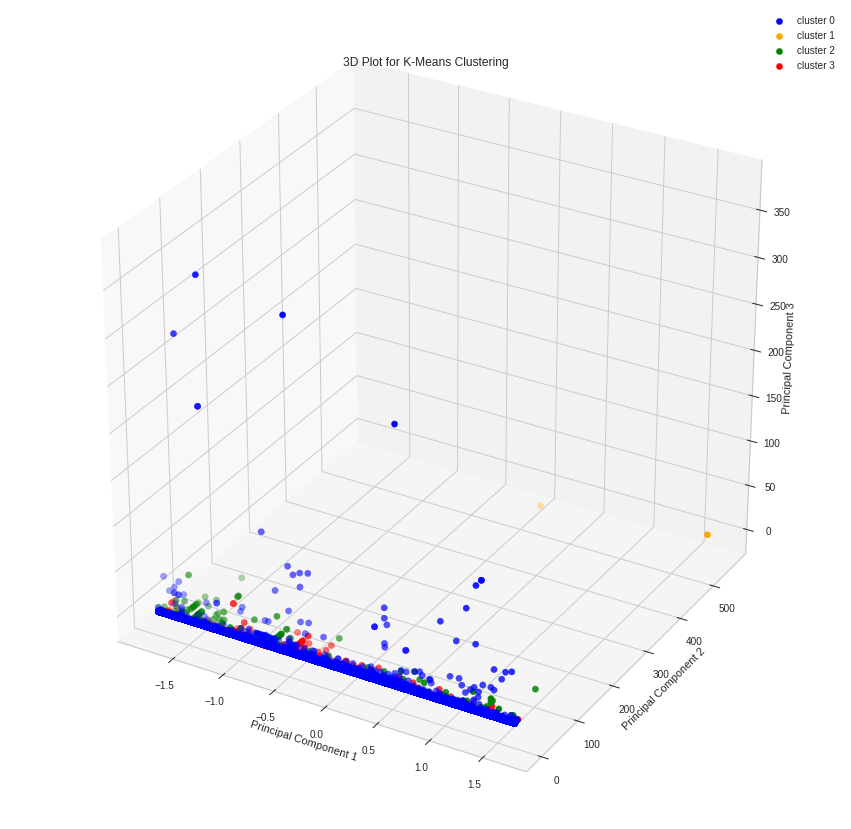

In [ ]:
# Visualizing the clusters on a 3D plot

fig = plt.figure(figsize = (15,15))

ax = fig.add_subplot(111, projection = "3d")
ax.scatter(values_df[kmeans_labels == 0,0], values_df[kmeans_labels == 0,1],values_df[kmeans_labels == 0,2], s = 30 , color = 'blue', label = "cluster 0")
ax.scatter(values_df[kmeans_labels == 1,0], values_df[kmeans_labels == 1,1],values_df[kmeans_labels == 1,2], s = 30 , color = 'orange', label = "cluster 1")
ax.scatter(values_df[kmeans_labels == 2,0], values_df[kmeans_labels == 2,1],values_df[kmeans_labels == 2,2], s = 30 , color = 'green', label = "cluster 2")
ax.scatter(values_df[kmeans_labels == 3,0], values_df[kmeans_labels == 3,1],values_df[kmeans_labels == 3,2], s = 30 , color = 'red', label = "cluster 3")
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D Plot for K-Means Clustering',
             loc ='center', )
ax.legend()
plt.show()

##Gaussian Mixture Model:

In [ ]:
# Gaussian Mixture component declaration
gmm =  GaussianMixture(n_components = 4, covariance_type='full', tol=0.001, reg_covar=0.10, max_iter=100)
gmm_predicted = gmm.fit_predict(pca_data)

print('Number of Points in Cluster 1:',np.count_nonzero(gmm_predicted == 0))
print('Number of Points in Cluster 2:',np.count_nonzero(gmm_predicted == 1))
print('Number of Points in Cluster 3:',np.count_nonzero(gmm_predicted == 2))
print('Number of Points in Cluster 4:',np.count_nonzero(gmm_predicted == 3))

Number of Points in Cluster 1: 321659
Number of Points in Cluster 2: 5185
Number of Points in Cluster 3: 414962
Number of Points in Cluster 4: 63814


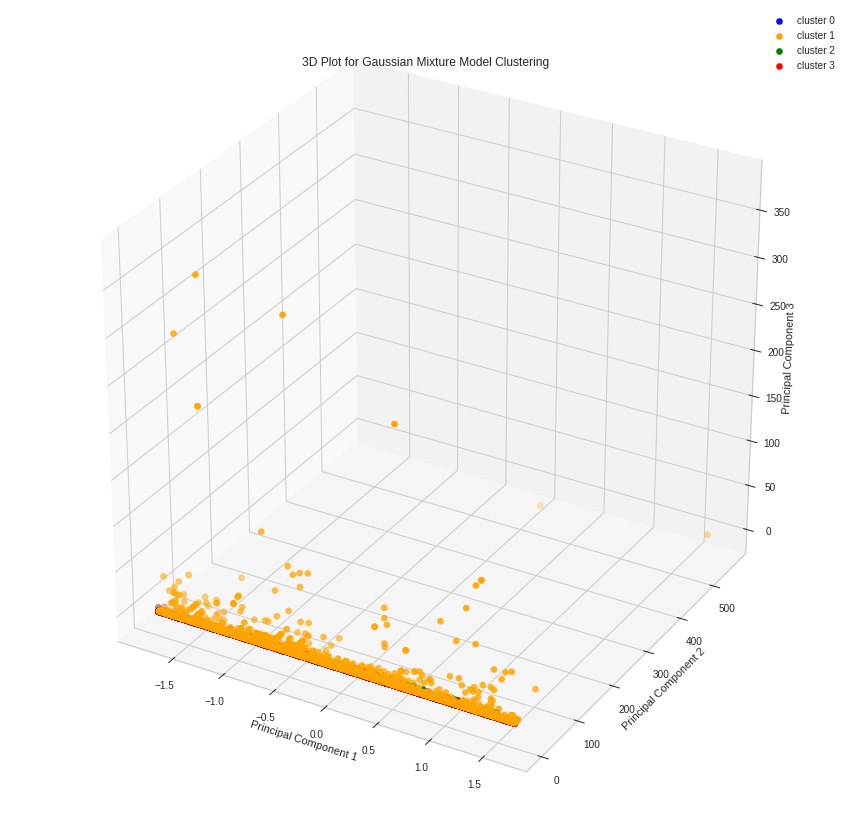

In [ ]:
# Visualizing the clusters on a 3D plot

fig = plt.figure(figsize = (15,15))

ax = fig.add_subplot(111, projection = "3d")
ax.scatter(values_df[gmm_predicted == 0,0], values_df[gmm_predicted == 0,1],values_df[gmm_predicted == 0,2], s = 30 , color = 'blue', label = "cluster 0")
ax.scatter(values_df[gmm_predicted == 1,0], values_df[gmm_predicted == 1,1],values_df[gmm_predicted == 1,2], s = 30 , color = 'orange', label = "cluster 1")
ax.scatter(values_df[gmm_predicted == 2,0], values_df[gmm_predicted == 2,1],values_df[gmm_predicted == 2,2], s = 30 , color = 'green', label = "cluster 2")
ax.scatter(values_df[gmm_predicted == 3,0], values_df[gmm_predicted == 3,1],values_df[gmm_predicted == 3,2], s = 30 , color = 'red', label = "cluster 3")
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D Plot for Gaussian Mixture Model Clustering',
             loc ='center', )
ax.legend()
plt.show()

##K-Means Mini Batch Clustering:

In [ ]:
miniBatch = MiniBatchKMeans(n_clusters = 4,max_iter=100, batch_size=1024)
miniBatch_clustering = miniBatch.fit(pca_data)
miniBatch_labels = miniBatch_clustering.labels_

print('Number of Points in Cluster 1:',np.count_nonzero(miniBatch_labels == 0))
print('Number of Points in Cluster 2:',np.count_nonzero(miniBatch_labels == 1))
print('Number of Points in Cluster 3:',np.count_nonzero(miniBatch_labels == 2))
print('Number of Points in Cluster 4:',np.count_nonzero(miniBatch_labels == 3))

Number of Points in Cluster 1: 272404
Number of Points in Cluster 2: 69309
Number of Points in Cluster 3: 243721
Number of Points in Cluster 4: 220186


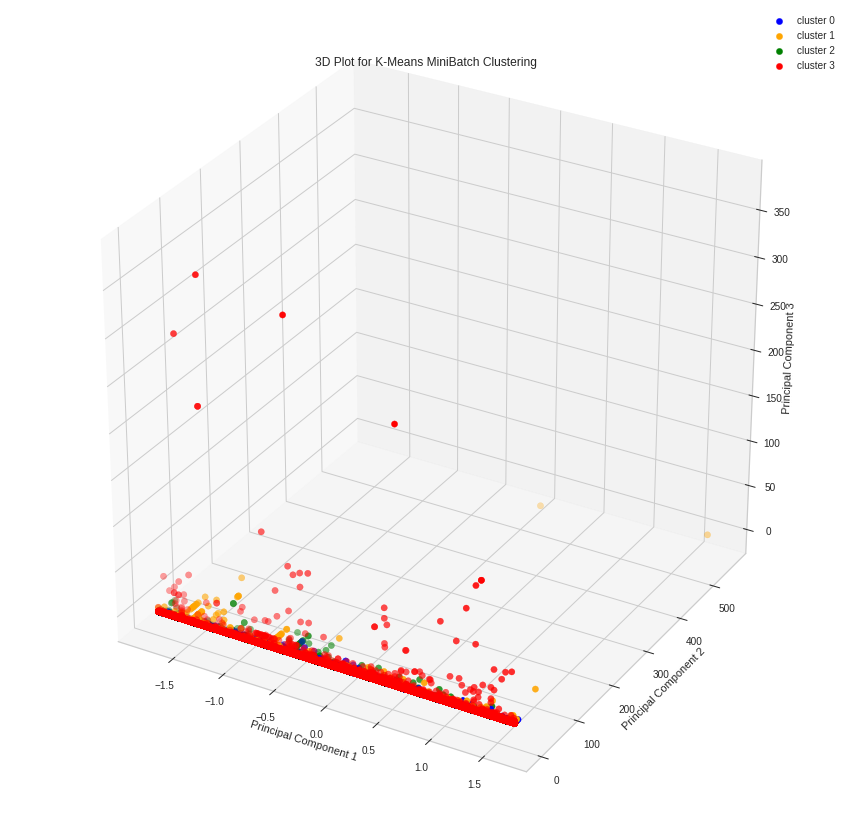

In [ ]:
# Visualizing the clusters on a 3D plot
fig = plt.figure(figsize = (15,15))

ax = fig.add_subplot(111, projection = "3d")
ax.scatter(values_df[miniBatch_labels == 0,0], values_df[miniBatch_labels == 0,1],values_df[miniBatch_labels == 0,2], s = 30 , color = 'blue', label = "cluster 0")
ax.scatter(values_df[miniBatch_labels == 1,0], values_df[miniBatch_labels == 1,1],values_df[miniBatch_labels == 1,2], s = 30 , color = 'orange', label = "cluster 1")
ax.scatter(values_df[miniBatch_labels == 2,0], values_df[miniBatch_labels == 2,1],values_df[miniBatch_labels == 2,2], s = 30 , color = 'green', label = "cluster 2")
ax.scatter(values_df[miniBatch_labels == 3,0], values_df[miniBatch_labels == 3,1],values_df[miniBatch_labels == 3,2], s = 30 , color = 'red', label = "cluster 3")
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D Plot for K-Means MiniBatch Clustering',
             loc ='center', )
ax.legend()
plt.show()

From the above plots, we see that the clusters that were formed were not that distinct and there was a lot of overlap in the cluster points. Furthermore, even after reducing the dimensionality and scaling the data, there were still some outliers that were skewing the data. So, we decided to perform RFM segmentation on the original dataset.

##RFM Segmentation
RFM segmentation is mainly used for marketing products or content to users based on their habits of interaction with the system. Marketers can basically use this method to maximize impressions on their website such as high click-rate, frequent online orders, etc. 
RFM stands for recency, frequency and monetary, each of which are traits exhibited by the users that interact with a particular website. In this section, we will derive the recency, frequency and monetary features based on the columns from the dataset. And then, we will use this transformed dataset to segment the users based on their spending habits.

Deriving monetary feature using the total amount spent by the user:

In [ ]:
# Getting the total amount spent by each customer for deriving the monetary feature
df_rfm = data_set.groupby(data_set["Customer ID"])['TotalPrice'].sum()
df_rfm = df_rfm.reset_index()
df_rfm.columns = ['Customer ID', 'GrossAmount']

Deriving the frequency feature using the total number of orders placed by a customer:

In [ ]:
# Deriving the frequency feature of the data set from the count of the customer purchases
frequency =data_set.groupby(data_set["Customer ID"])["Invoice"].count()
frequency =frequency.reset_index()
frequency.columns = ['Customer ID', 'TotalOrders']


Deriving recency using the latest invoice date for a customer:

In [ ]:
# Deriving the recency 
max_date = max(data_set['InvoiceDate'])
data_set['diff'] = max_date - data_set['InvoiceDate']
last_purchase = data_set.groupby('Customer ID')['diff'].min().dt.days
last_purchase = last_purchase.reset_index()
last_purchase.columns = ['Customer ID', 'LatestOrder']

df_rfm = pd.merge(df_rfm, frequency, on = 'Customer ID', how ='inner')
df_rfm = pd.merge(df_rfm, last_purchase, on = 'Customer ID', how = 'inner')

Density plot and box plot for RFM features before removing outliers:

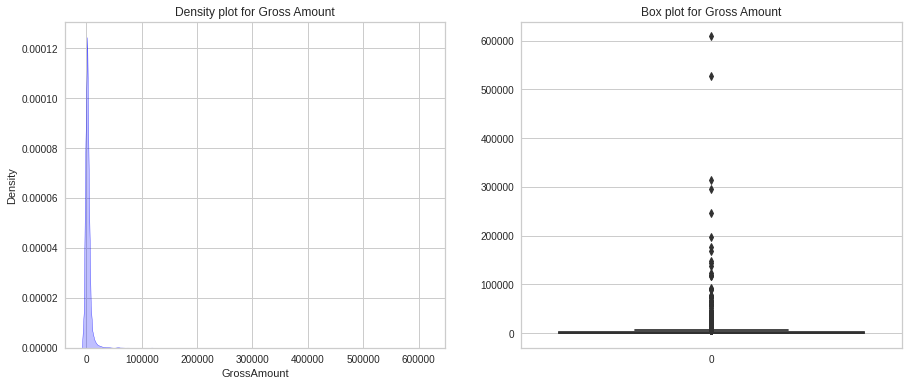

In [ ]:
fig=plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
ax=sns.kdeplot(df_rfm["GrossAmount"], color="blue", fill=True)
ax.title.set_text('Density plot for Gross Amount')

plt.subplot(1,2,2)
ax1=sns.boxplot(data=df_rfm["GrossAmount"])
ax1.title.set_text('Box plot for Gross Amount')

fig.show()

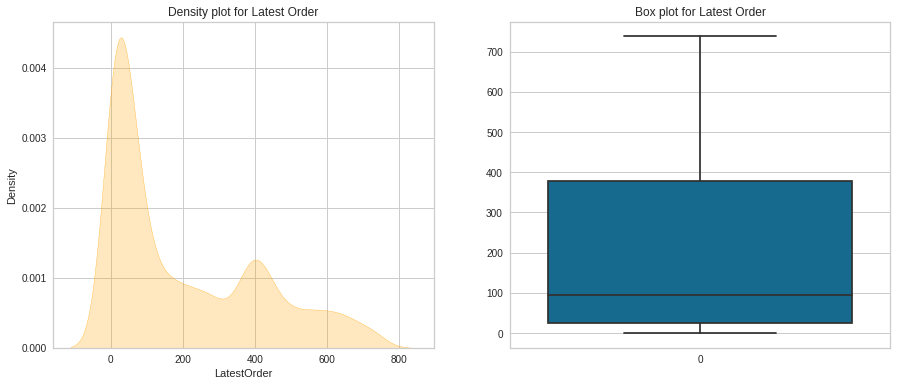

In [ ]:
fig=plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
ax=sns.kdeplot(df_rfm["LatestOrder"], color="orange", fill=True)
ax.title.set_text('Density plot for Latest Order')

plt.subplot(1, 2, 2)
ax1=sns.boxplot(data=df_rfm["LatestOrder"])
ax1.title.set_text('Box plot for Latest Order')
fig.show()

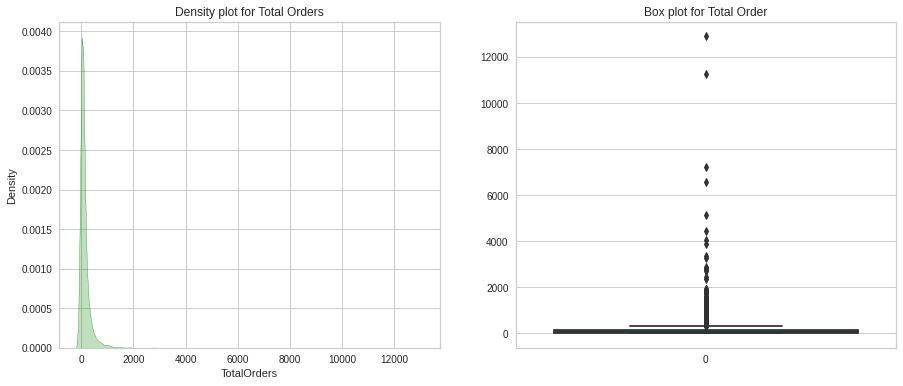

In [ ]:
fig=plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
ax=sns.kdeplot(df_rfm["TotalOrders"], color="green", fill=True)
ax.title.set_text('Density plot for Total Orders')

plt.subplot(1, 2, 2)
ax1=sns.boxplot(data=df_rfm["TotalOrders"])
ax1.title.set_text('Box plot for Total Orders')
fig.show()

Removing outliers and visualizing the distributions for the RFM features:

In [ ]:
# Removing outliers based on percentiles
stats = df_rfm.describe([0.25, 0.5, 0.75, 0.9])
stats

for col in df_rfm.columns:
  df_rfm.loc[df_rfm[col] > stats[col]['90%'], col] = stats[col]['90%']

In [ ]:
df_rfm.describe()

,Customer ID,GrossAmount,TotalOrders,LatestOrder
count,5881.000000,5881.000000,5881.000000,5881.000000
mean,15285.035878,1647.791733,97.030097,191.009352
std,1670.011072,1759.912108,101.411896,190.300991
min,12346.000000,0.000000,1.000000,0.000000
25%,13833.000000,347.800000,21.000000,25.000000
50%,15313.000000,897.620000,53.000000,95.000000
75%,16797.000000,2304.180000,142.000000,379.000000
max,17696.000000,5594.960000,318.000000,535.000000


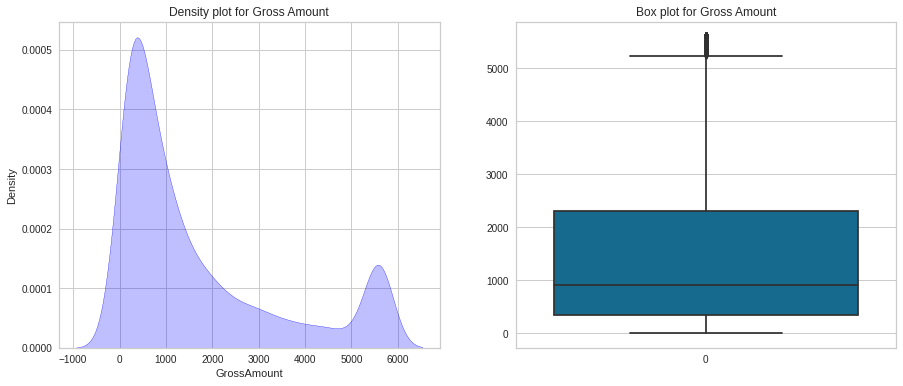

In [ ]:
fig=plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
ax=sns.kdeplot(df_rfm["GrossAmount"], color="blue", fill=True)
ax.title.set_text('Density plot for Gross Amount')

plt.subplot(1,2,2)
ax1=sns.boxplot(data=df_rfm["GrossAmount"])
ax1.title.set_text('Box plot for Gross Amount')
fig.show()

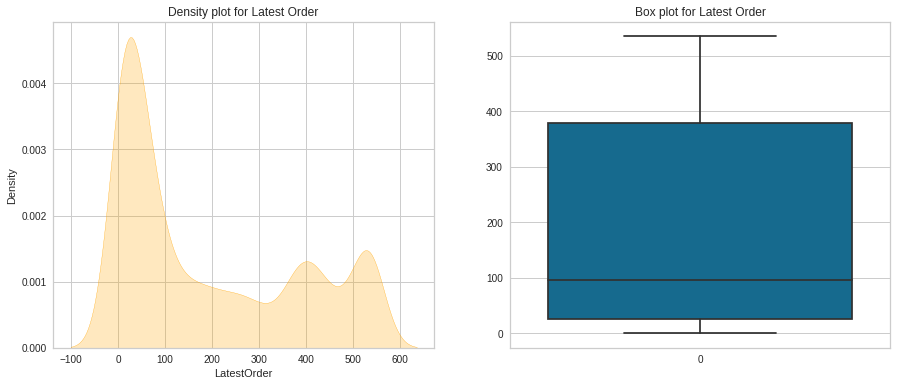

In [ ]:
fig=plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
ax=sns.kdeplot(df_rfm["LatestOrder"], color="orange", fill=True)
ax.title.set_text('Density plot for Latest Order')

plt.subplot(1, 2, 2)
ax1=sns.boxplot(data=df_rfm["LatestOrder"])
ax1.title.set_text('Box plot for Latest Order')
fig.show()

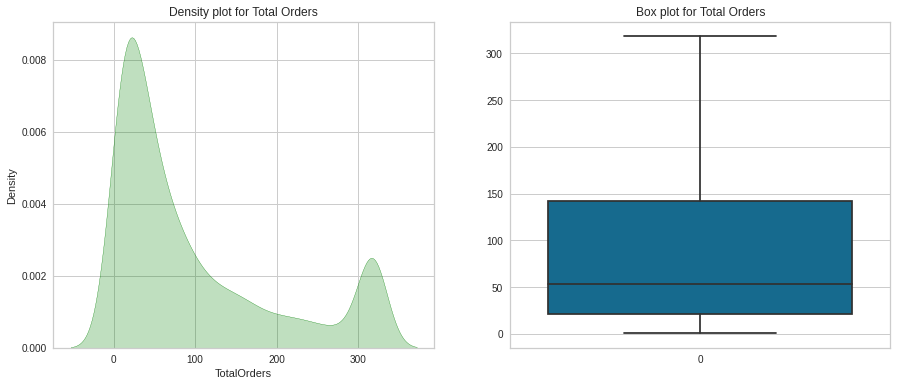

In [ ]:
fig=plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
ax=sns.kdeplot(df_rfm["TotalOrders"], color="green", fill=True)
ax.title.set_text('Density plot for Total Orders')

plt.subplot(1, 2, 2)
ax1=sns.boxplot(data=df_rfm["TotalOrders"])
ax1.title.set_text('Box plot for Total Orders')
fig.show()

Now, looking at the distribution, we can say that it is quite balanced and does not have those many outliers.

##Data Preprocessing
Scaling the dataset using StandardScaler() to ensure that the data is properly distributed and is on the same scale.

In [ ]:
# Standardizing the rfm data frame for scaling the values
scaled_values = StandardScaler().fit_transform(df_rfm[['GrossAmount','TotalOrders','LatestOrder']])
rfm_df_scaled = pd.DataFrame(scaled_values)
rfm_df_scaled.columns = ['GrossAmount', 'TotalOrders', 'LatestOrder']

rfm_df_scaled.describe()

,GrossAmount,TotalOrders,LatestOrder
count,5.881000e+03,5.881000e+03,5.881000e+03
mean,-6.282643e-17,-2.355991e-17,9.786424e-17
std,1.000085e+00,1.000085e+00,1.000085e+00
min,-9.363717e-01,-9.470118e-01,-1.003808e+00
25%,-7.387314e-01,-7.497795e-01,-8.724257e-01
50%,-4.262915e-01,-4.342078e-01,-5.045560e-01
75%,3.729982e-01,4.434758e-01,9.879435e-01
max,2.243012e+00,2.179120e+00,1.807767e+00


In [ ]:
# Creating a 2D Matrix for fitting data
val = rfm_df_scaled[['GrossAmount', 'TotalOrders', 'LatestOrder']].values

# Creating a 2D Matrix for Plotting  graphs
plot_df = df_rfm[['GrossAmount', 'TotalOrders', 'LatestOrder']].values

Again, using the K-Means Elbow Method, we obtain the optimal number of clusters for the RFM dataset.

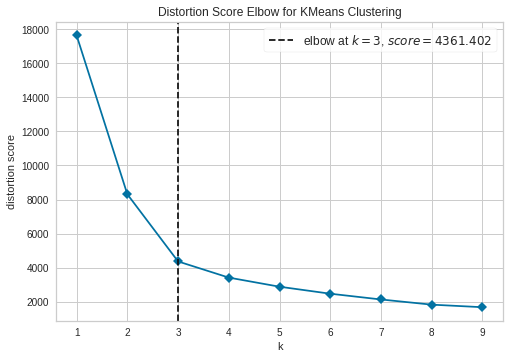

In [ ]:
# Using K-Means Elbow Method to find the right amount of clusters
X = rfm_df_scaled.iloc[:,:].values
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(1,10), timings=False
)
visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show() 

In [ ]:
# As shown in the elbow plot, k = 3 is the most optimal value for number of clusters
kmeans = KMeans(n_clusters=3, max_iter=100, random_state=15) 
kmeans_labels = kmeans.fit_predict(val)
df_rfm['kmeans_labels'] = kmeans.labels_

print('Number of Points in Cluster 1:',np.count_nonzero(kmeans_labels == 0))
print('Number of Points in Cluster 2:',np.count_nonzero(kmeans_labels == 1))
print('Number of Points in Cluster 3:',np.count_nonzero(kmeans_labels == 2))

Number of Points in Cluster 1: 1313
Number of Points in Cluster 2: 2594
Number of Points in Cluster 3: 1974


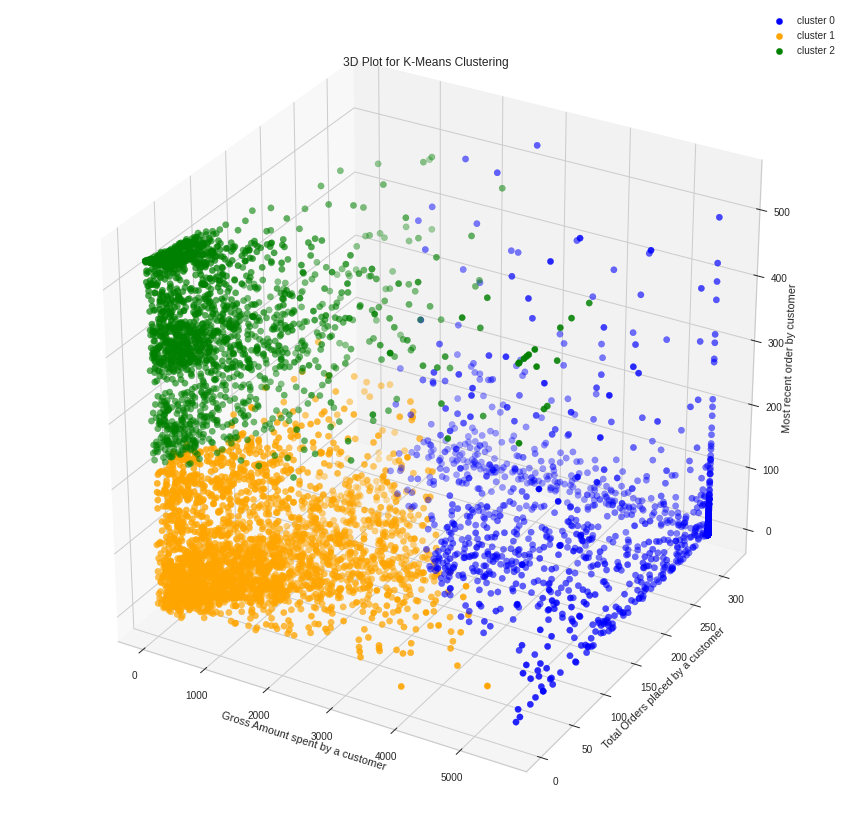

In [ ]:
# Plotting a 3D graph for the K-Means Clustering
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(plot_df[kmeans_labels == 0,0], plot_df[kmeans_labels == 0,1], plot_df[kmeans_labels == 0,2], s = 30 , color = 'blue', label = "cluster 0")
ax.scatter(plot_df[kmeans_labels == 1,0], plot_df[kmeans_labels == 1,1], plot_df[kmeans_labels == 1,2], s = 30 , color = 'orange', label = "cluster 1")
ax.scatter(plot_df[kmeans_labels == 2,0], plot_df[kmeans_labels == 2,1], plot_df[kmeans_labels == 2,2], s = 30 , color = 'green', label = "cluster 2")
ax.set_xlabel('Gross Amount spent by a customer')
ax.set_ylabel('Total Orders placed by a customer')
ax.set_zlabel('Most recent order by customer')
ax.set_title('3D Plot for K-Means Clustering',
             loc ='center', )
ax.legend()
plt.show()

In [ ]:
# Spectral Clustering
spectral_model = SpectralClustering(n_clusters=3, affinity='rbf', random_state=15, gamma=0.001) # 101
spectral_labels = spectral_model.fit_predict(val)

print('Number of Points in Cluster 1:',np.count_nonzero(spectral_model.labels_ == 0))
print('Number of Points in Cluster 2:',np.count_nonzero(spectral_model.labels_ == 1))
print('Number of Points in Cluster 3:',np.count_nonzero(spectral_model.labels_ == 2))

Number of Points in Cluster 1 1892
Number of Points in Cluster 2 2720
Number of Points in Cluster 3 1269


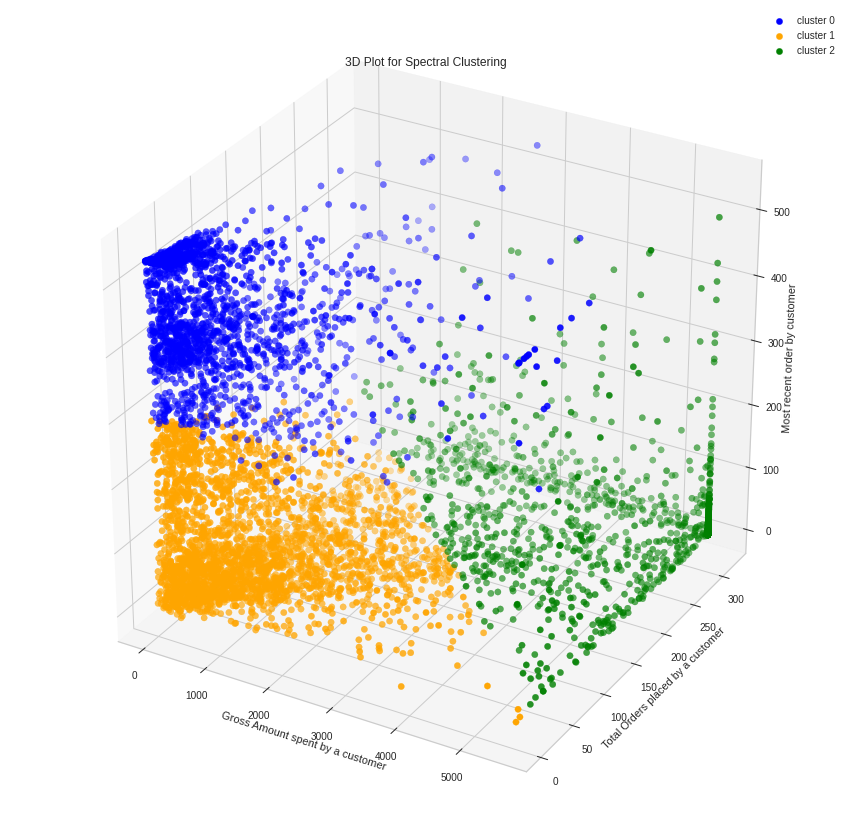

In [ ]:
# Plotting a 3D graph for the Spectral Clustering

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(plot_df[spectral_labels == 0,0], plot_df[spectral_labels == 0,1], plot_df[spectral_labels == 0,2], s = 30 , color = 'blue', label = "cluster 0")
ax.scatter(plot_df[spectral_labels == 1,0], plot_df[spectral_labels == 1,1], plot_df[spectral_labels == 1,2], s = 30 , color = 'orange', label = "cluster 1")
ax.scatter(plot_df[spectral_labels == 2,0], plot_df[spectral_labels == 2,1], plot_df[spectral_labels == 2,2], s = 30 , color = 'green', label = "cluster 2")
ax.set_xlabel('Gross Amount spent by a customer')
ax.set_ylabel('Total Orders placed by a customer')
ax.set_zlabel('Most recent order by customer')
ax.set_title('3D Plot for Spectral Clustering',
             loc ='center', )
ax.legend()
plt.show()

In [ ]:
# Gaussian Mixture Model
gmm = GaussianMixture(n_components=3, reg_covar=0.1, random_state=15)
gmm_preds = gmm.fit_predict(val)

print('Number of Points in Cluster 1:',np.count_nonzero(gmm_preds == 0))
print('Number of Points in Cluster 2:',np.count_nonzero(gmm_preds == 1))
print('Number of Points in Cluster 3:',np.count_nonzero(gmm_preds == 2))

Number of Points in Cluster 1 1385
Number of Points in Cluster 2 2439
Number of Points in Cluster 3 2057


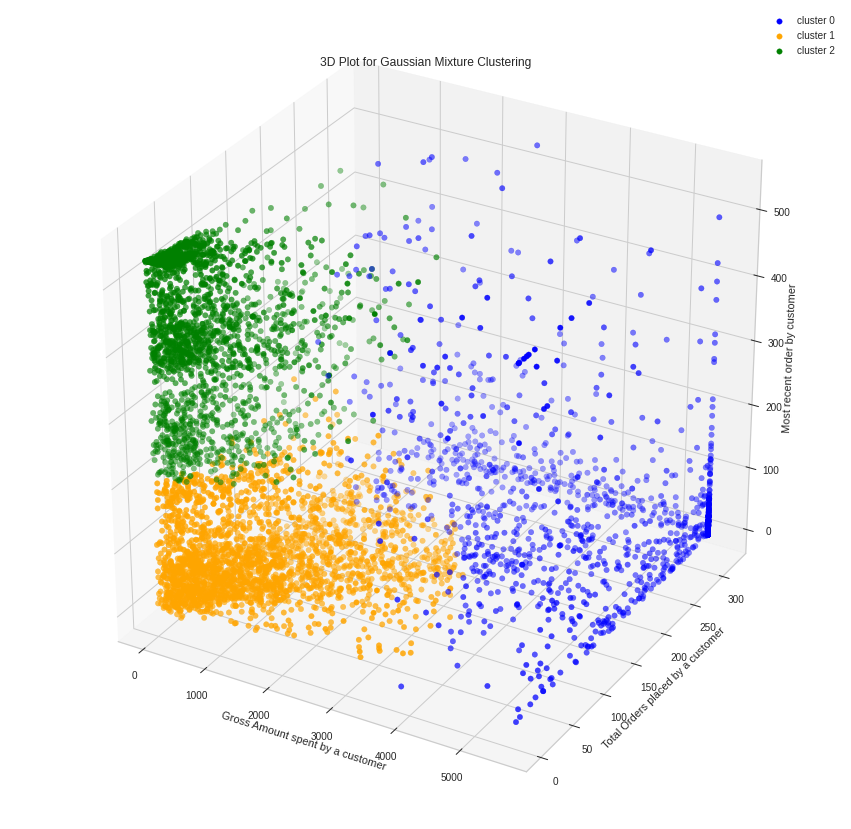

In [ ]:
# 3D Graph for Gaussian Mixture Model

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(plot_df[gmm_preds == 0,0], plot_df[gmm_preds == 0,1], plot_df[gmm_preds == 0,2], s = 30, color = 'blue', label = "cluster 0")
ax.scatter(plot_df[gmm_preds == 1,0], plot_df[gmm_preds == 1,1], plot_df[gmm_preds == 1,2], s = 30, color = 'orange', label = "cluster 1")
ax.scatter(plot_df[gmm_preds == 2,0], plot_df[gmm_preds == 2,1], plot_df[gmm_preds == 2,2], s = 30, color = 'green', label = "cluster 2")
ax.set_xlabel('Gross Amount spent by a customer')
ax.set_ylabel('Total Orders placed by a customer')
ax.set_zlabel('Most recent order by customer')
ax.set_title('3D Plot for Gaussian Mixture Clustering',
             loc ='center', )
ax.legend()
plt.show()

##Evaluating Models

Since we are using unsupervised machine learning techniques on an online dataset, we do not have the actual cluster labels for the users. This prevents us from using evaluation metrics such as accuracy, homogeneity or completeness score. So, for our models, we will use the silhouette score to evaluate the quality of the clusters obtained by modelling using the various clustering algorithms.

In [ ]:
# Printing silhouette score
print('Silhouette score for K-Means Clustering:', 
      round(silhouette_score(df_rfm[['GrossAmount', 'TotalOrders', 'LatestOrder']], kmeans_labels), 4))
print('Silhouette score for Spectral Clustering:', 
      round(silhouette_score(df_rfm[['GrossAmount', 'TotalOrders', 'LatestOrder']], spectral_labels), 4))
print('Silhouette score for Gaussian Mixture Model:',
      round(silhouette_score(df_rfm[['GrossAmount', 'TotalOrders', 'LatestOrder']], gmm_preds), 4))

Silhouette score for K-Means Clustering: 0.2266
Silhouette score for Spectral Clustering: 0.2056
Silhouette score for Gaussian Mixture Model: 0.2243


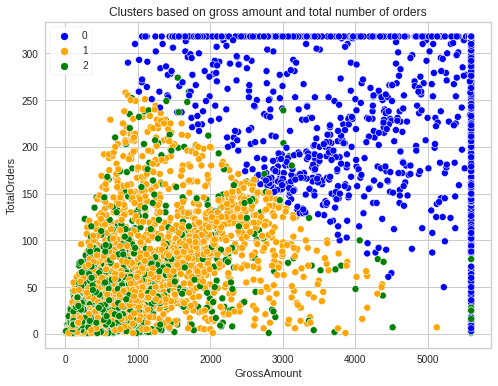

In [ ]:
# Clusters based on gross amount and total number of orders
pal = ['blue', 'orange', 'green']
fig = plt.figure(figsize = (8, 6))
pl = sns.scatterplot(data = df_rfm, x=df_rfm["GrossAmount"], y=df_rfm["TotalOrders"], hue=df_rfm["kmeans_labels"], palette=pal)
pl.set_title("Clusters based on gross amount and total number of orders")
plt.legend(frameon=True)
plt.show()

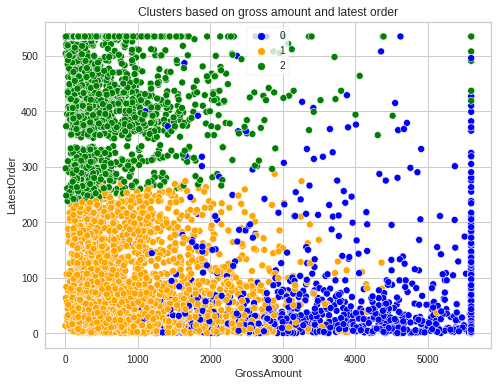

In [ ]:
# Clusters based on gross amount and latest order
pal = ['blue', 'orange', 'green']
fig = plt.figure(figsize = (8, 6))
pl = sns.scatterplot(data = df_rfm, x=df_rfm["GrossAmount"], y=df_rfm["LatestOrder"], hue=df_rfm["kmeans_labels"], palette=pal)
pl.set_title("Clusters based on gross amount and latest order")
plt.legend(frameon=True)
plt.show()

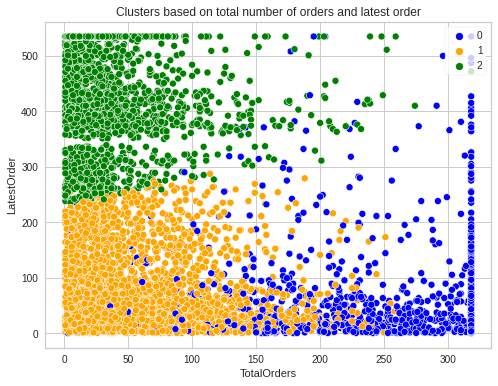

In [ ]:
# Clusters based on total number of orders and latest order
pal = ['blue', 'orange', 'green']
fig = plt.figure(figsize = (8, 6))
pl = sns.scatterplot(data = df_rfm, x=df_rfm["TotalOrders"], y=df_rfm["LatestOrder"], hue=df_rfm["kmeans_labels"], palette=pal)
pl.set_title("Clusters based on total number of orders and latest order")
plt.legend(frameon=True)
plt.show()

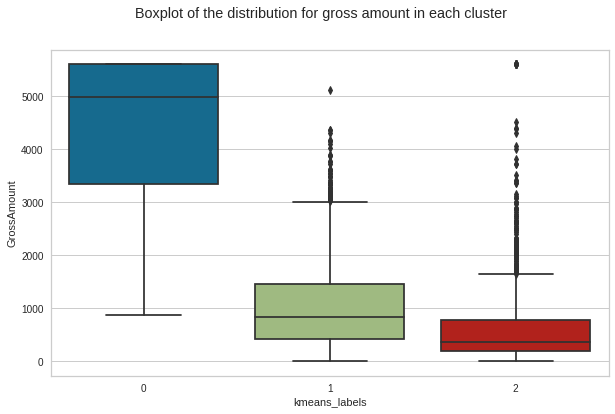

In [ ]:
# Boxplot of the distribution for gross amount in each cluster
fig=plt.figure(figsize=(10, 6))
fig.suptitle('Boxplot of the distribution for gross amount in each cluster')

ax=sns.boxplot(x='kmeans_labels', y='GrossAmount', data=df_rfm)

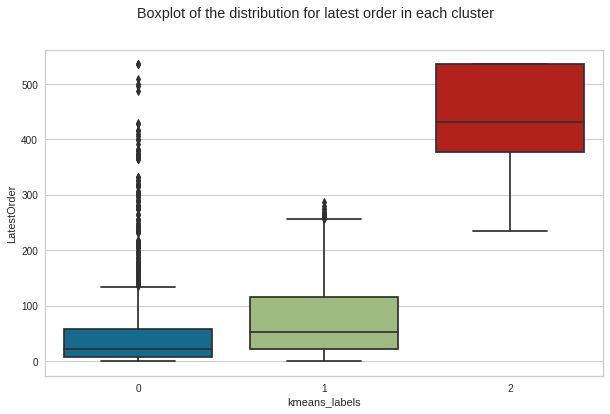

In [ ]:
# Boxplot of the distribution for latest order in each cluster
fig=plt.figure(figsize=(10, 6))
fig.suptitle('Boxplot of the distribution for latest order in each cluster')

ax=sns.boxplot(x='kmeans_labels', y='LatestOrder', data=df_rfm)

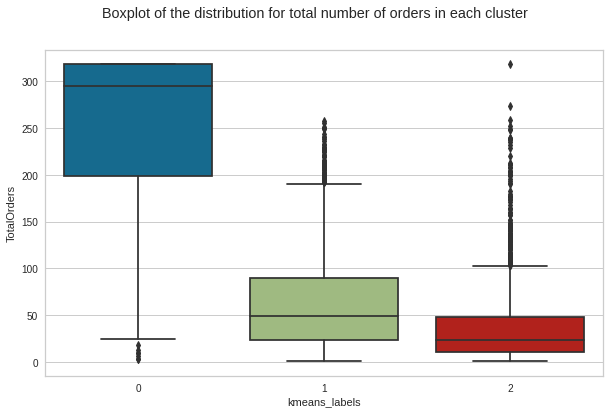

In [ ]:
# Boxplot of the distribution for total number of orders in each cluster
fig=plt.figure(figsize=(10, 6))
fig.suptitle('Boxplot of the distribution for total number of orders in each cluster')

ax=sns.boxplot(x='kmeans_labels', y='TotalOrders', data=df_rfm)

From the above analysis, we can see that the clusters formed by using RFM segmentation were much more defined and easily interpretable. These clusters can inform further analysis that we do and can also help in providing personalized recommendations to users based on their previous orders and how frequently they order.